In [2]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler

# Problem 1: Reimplement t-SNE

Steps:

<br>**In high dimensional state**
- Calculate the euclidean distance between every pair of points
- Calculate similarities (condition probability follow Gaussian dist), p_joint 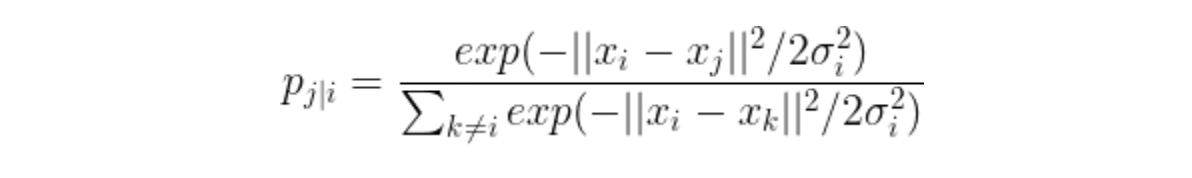
- Binary search to find sigma with given perplexity

<br>**For low-dimensional representation**: Samp
- Calculate q_joint follow t-distribution
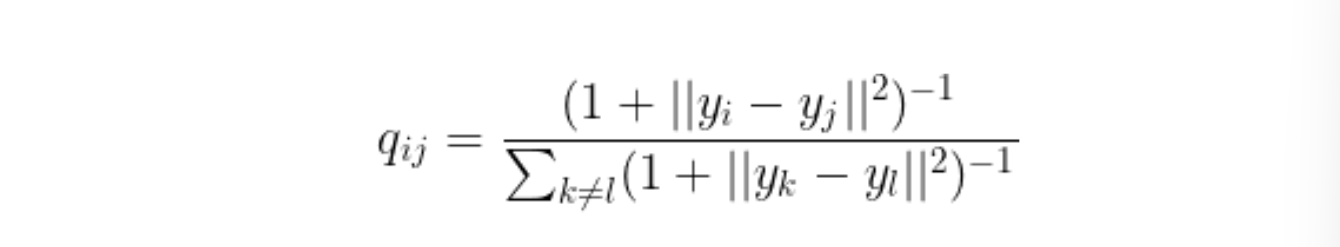
- Optimize Q to be close to P: Minimize KL-divergence. Obtain gradient with formula below:
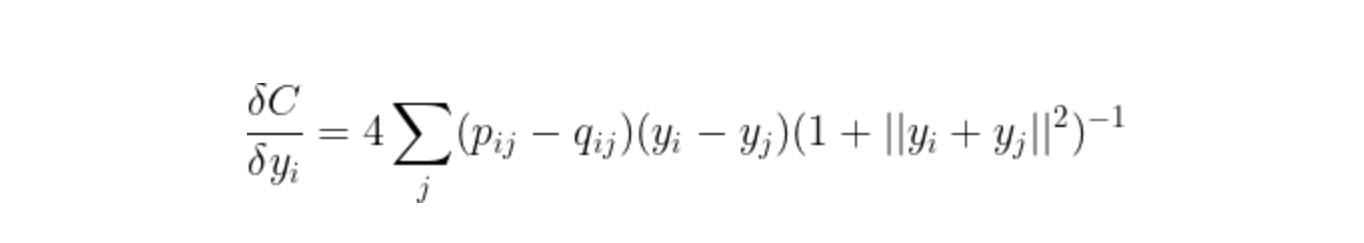
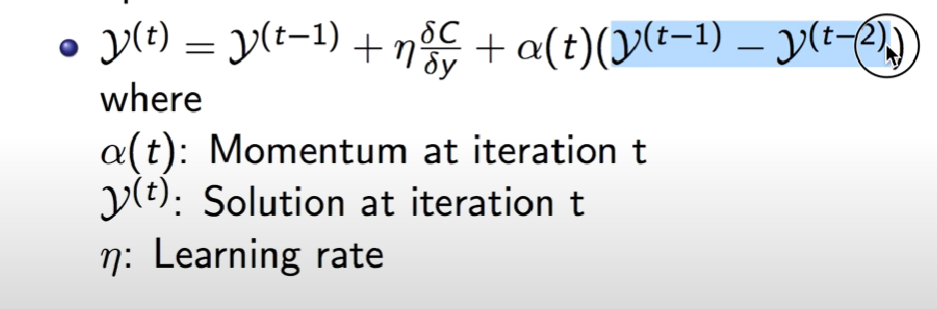

In [3]:
def binary_search(func, goal, tol =1e-10, max_iters = 1000, lowb=1e-20, uppb =10000):
    for _ in range(max_iters):
        guess = (uppb + lowb) / 2
        val = func(guess)

        if val > goal:
            uppb = guess
        else:
            lowb = guess
        
        if np.abs(val - goal) <= tol:
            break
        return guess

In [4]:
class tSNE:
    
    def __init__(self, ydim, iteration = 1000, learning_rate = 500, perp = 30):
        self.ydim = ydim
        self.iter = iteration
        self.learn = learning_rate
        self.perp = perp
    
    def _pairwise_distance(self,X):
        return np.sum((X[None, :] - X[:, None])**2, 2)
    
    def _p_conditional(self, distances, sigmas):
        e = np.exp(-distances / (2*np.square(sigmas.reshape(-1,1))))
        np.fill_diagonal(e,0)
        e += 1e-8
        return e/e.sum(axis=1).reshape([-1,1])
    
    def _perp(self,condition_maxtrix):
        entropy = -np.sum(condition_maxtrix * np.log2(condition_maxtrix))
        return 2 ** entropy
    
    def _find_sigmas(self,distances, perplexity):
        found_sigmas = np.zeros(distances.shape[0])
        for i in range(distances.shape[0]):
            func = lambda sig: self._perp(self._p_conditional(distances[i:i+1,:], np.array([sig])))
            found_sigmas[i] = binary_search(func, perplexity)
        return found_sigmas

    def _q_joint(self,y):
        dists = self._pairwise_distance(y)
        nom = 1 / (1 + dists)
        np.fill_diagonal(nom, 0.)
        return nom / np.sum(np.sum(nom))
    
    def _gradient(self, P, Q, y):
        (N, num_dims) = y.shape
        pq_diff = P - Q
        y_diff = np.expand_dims(y,1) - np.expand_dims(y,0)

        dists = self._pairwise_distance(y)
        aux = 1 / (1+ dists)
        return 4 * (np.expand_dims(pq_diff, 2) * y_diff * np.expand_dims(aux,2)).sum(1)
    
    def __momentum(self,t):
        return 0.5 if t < 250 else 0.8

    def _p_joint(self, X, perp):
        N = X.shape[0]
        distances = self._pairwise_distance(X)
        sigmas = self._find_sigmas(distances, perp)
        p_cond = self._p_conditional(distances, sigmas)
        return (p_cond + p_cond.T) / (2 * N)

    def fit_transform(self, X):
        N = X.shape[0]
        P = self._p_joint(X,self.perp)

        Y = []
        y = np.random.normal(loc=0.0, scale=1e-4, size = (N,self.ydim))
        Y.append(y); Y.append(y)

        # gradient descent
        for t in range(self.iter):
            Q = self._q_joint(Y[-1])
            grad = self._gradient(P, Q, Y[-1])
            y = Y[-1] - self.learn * grad + self.__momentum(t) * (Y[-1] - Y[-2])
            Y.append(y)
            
            if t % 10 == 0:
                Q = np.maximum(Q, 1e-12)
        return y

# Problem 2 + 3:

In [5]:
from sklearn import datasets
X,y = datasets.load_digits(return_X_y=True)

In [14]:
tsne = tSNE(ydim=2, iteration=10_000, learning_rate=200, perp=20)
X_embedded = tsne.fit_transform(X)

Text(0.5, 1.0, 't-SNE 2D embedded')

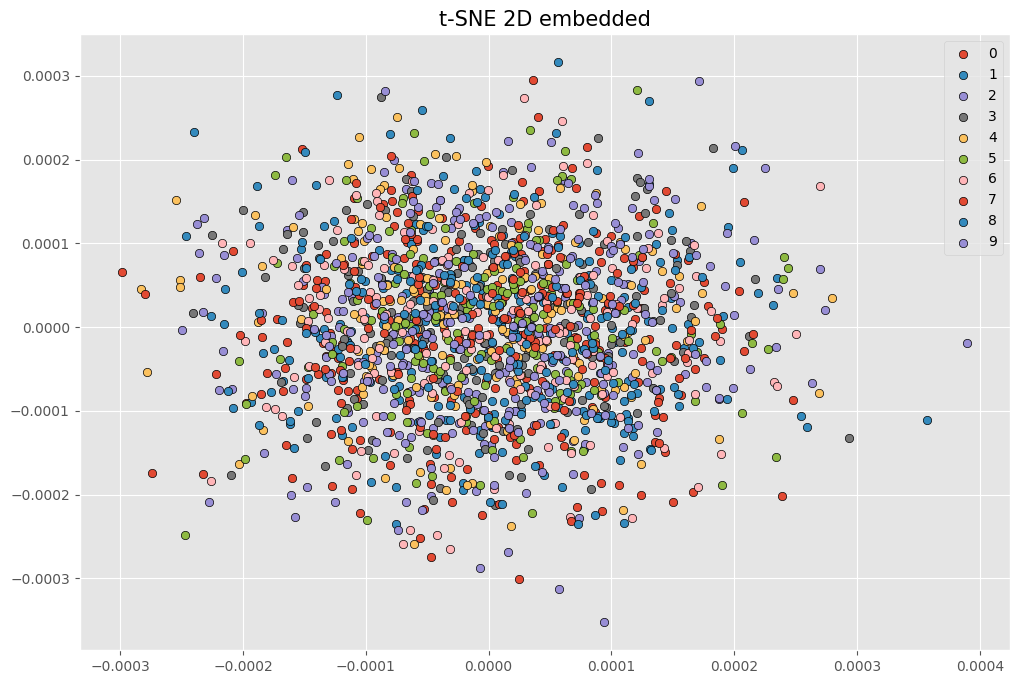

In [13]:
# Visualize reduced dimension datasets
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12, 8))
for tag in set(y):
    plt.scatter(x=X_embedded[np.where(y == tag), 0], y=X_embedded[np.where(
        y == tag), 1],edgecolors='black', label=tag)
# plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s=20, c=y)
plt.legend(loc="upper right")
plt.title('t-SNE 2D embedded',size = 15)

In [8]:
# tsne3D = tSNE(ydim=3, iteration=1000, learning_rate=200, perp=20)
# X_embedded_3D = tsne.fit_transform(X)

## Compare With PCA

In [9]:
class PCA:

    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None

    def fit(self, X):
        # mean
        self.mean = np.mean(X, axis=0)
        X = X - self.mean

        # covariance matrix
        # covariance_matrix = (1 / np.shape(X)[0]) * np.diag(X.T.dot(X))
        covariance_matrix = np.cov(X.T)

        # eigenvectors, eigenvalues
        eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

        # sort eigenvectors
        eigenvectors = eigenvectors.T
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[idx]

        # keep first n eigenvectors
        self.components = eigenvectors[:self.n_components]

        return

    def transform(self, X):
        # project data
        X = X - self.mean
        return np.dot(X, self.components.T)

In [10]:
pca = PCA(2)
pca.fit(X)
X_reduced = pca.transform(X)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


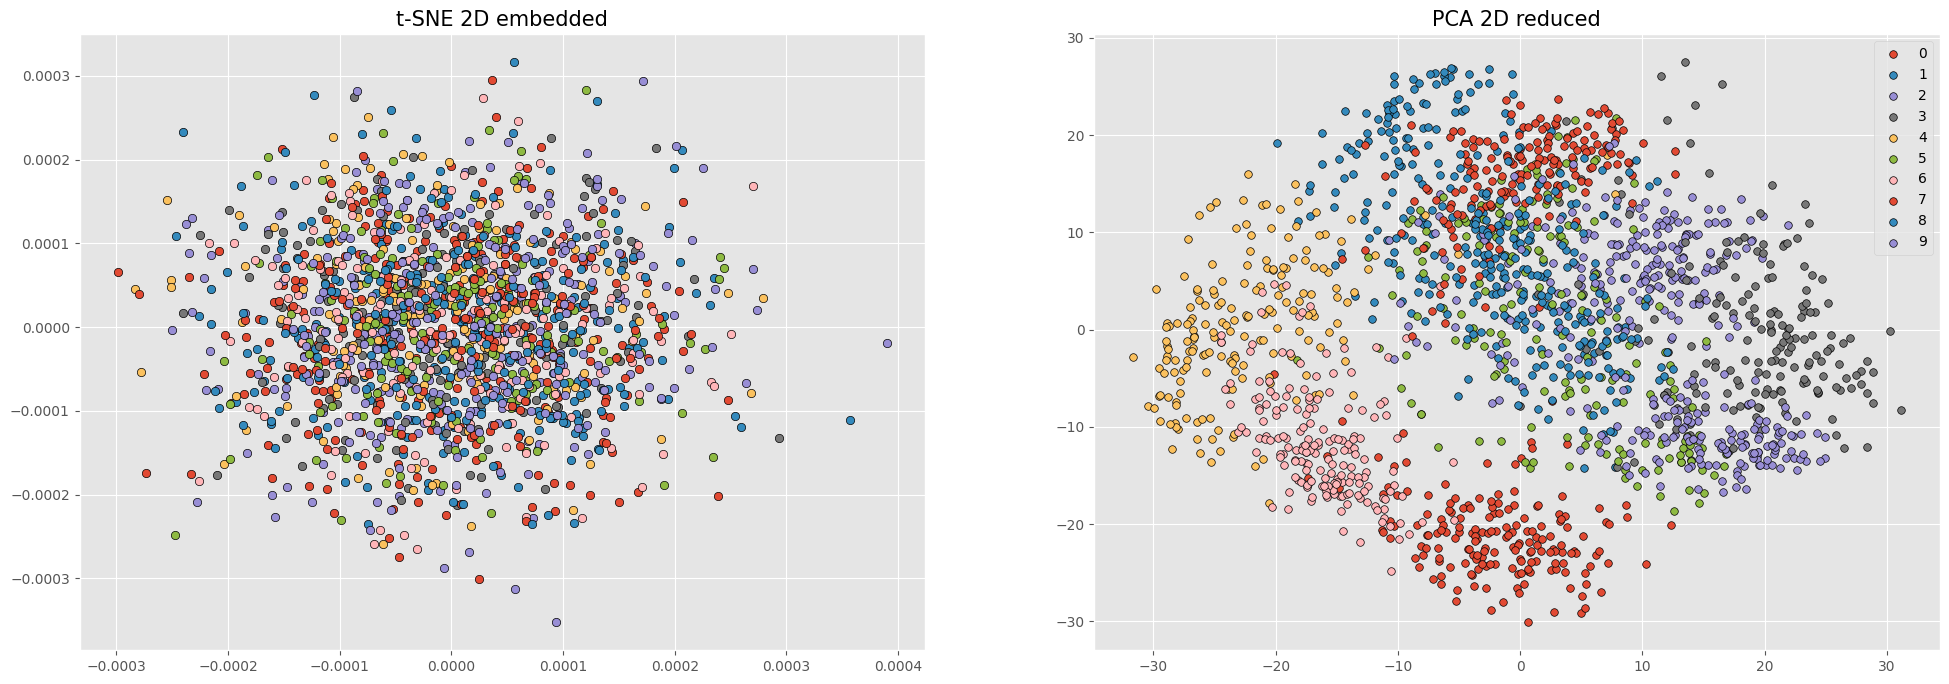

In [11]:
# Visualize reduced dimension datasets
plt.style.use('ggplot')
fig, axes = plt.subplots(1,2,figsize=(24, 8))

# tsne 2D
for tag in set(y):
    axes[0].scatter(x=X_embedded[np.where(y == tag), 0], y=X_embedded[np.where(
        y == tag), 1], edgecolors='black', label=tag)

plt.legend(loc="upper right")
axes[0].set_title('t-SNE 2D embedded',size=15)

# pca 2d
for tag in set(y):
    axes[1].scatter(x=X_reduced[np.where(y == tag), 0], y=X_reduced[np.where(y == tag), 1], s=30, edgecolors='black', label=tag)
# plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s=20, c=y)
axes[1].set_title('PCA 2D reduced', size = 15)
plt.legend(loc="upper right")

**Observation**:
- It is clearly that the PCA method handles pretty well with the large dataset. While the tSNE algorithm makes thing disorder (this might because my coding in finding perplexity is wrong)

**tSNE embedded 2D on sklearn**

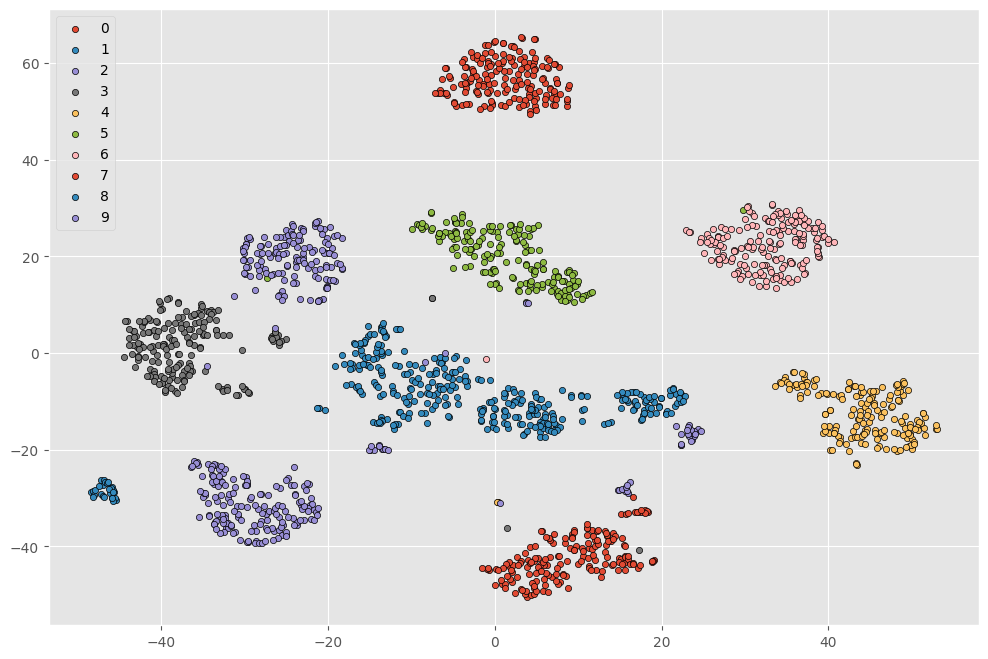

In [12]:
from sklearn.manifold import TSNE
TSNE = TSNE(n_components=2, perplexity=30)
data_2d = TSNE.fit_transform(X)

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12, 8))
for tag in set(y):
    plt.scatter(x=data_2d[np.where(y == tag), 0], y=data_2d[np.where(
        y == tag), 1], s=20, edgecolors='black', label=tag)
plt.legend(loc = 'upper left')